### CUNY Data 620 - Web Analytics, Summer 2020
**Group Project 1**  
**Prof:** Alain Ledon  
**Members:** Misha Kollontai, Amber Ferger, Zach Alexander, Subhalaxmi Rout  

### Instructions
1. Identify a large 2-node network dataset—you can start with a dataset in a repository.  Your data should meet the criteria that it consists of ties between and not within two (or more) distinct groups.
2. Reduce the size of the network using a method such as the island method described in chapter 4 of social network analysis.
3. What can you infer about each of the distinct groups?

In [43]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as spy
import numpy as np
import statistics

In [44]:
composerFile = "data/composers.txt"

composers = []
composerfile = open(composerFile, 'r') 
for line in composerfile.readlines(): 
    for element in line[0:-1].split('\t'):
        composers.append(element)
composers = [item for item in composers if composers not in ['\n', '']]
composers = [string for string in composers if string != ""]

In [45]:
producerFile = "data/producers.txt"

producers = []
producerfile = open(producerFile, 'r') 
for line in producerfile.readlines(): 
    for element in line[0:-1].split('\t'):
        producers.append(element)
producers = [item for item in producers if producers not in ['\n', ',']]
producers = [string for string in producers if string != ""]

In [35]:
interaction_matrix = "data/matrix.txt"

interaction_mat = []
interactfile = open(interaction_matrix, 'r') 
for line in interactfile.readlines(): 
    for element in line[0:-1].split('\n'):
        interaction_mat.append(element)
interaction_mat = [item for item in interaction_mat if interaction_mat not in ['\n', '']]
interaction_mat = [string for string in interaction_mat if string != ""]

In [36]:
producers = "\n".join(producers)
composers = "\n".join(composers)
interaction_mat = "\n".join(interaction_mat)

In [37]:
def hollywood_graph(create_using=None, **kwds):
    composers_num=40
    producers_num=62
    g=nx.generators.empty_graph(composers_num+producers_num,create_using=create_using,**kwds)
    g.clear()
    g.name="Hollywood Film Music"
    
    # loading the women's names
    producers_list=producers

    # loading the club names
    composers_list=composers

    # loading the interaction matrix
    interaction_matrix=interaction_mat
    
    # creating a list of women names
    c={}
    n=0
    for name in composers_list.split('\n'):
        c[n]=name
        n+=1

    # creating a list of club names
    p={}
    n=0
    for name in producers_list.split('\n'):
        p[n]=name
        n+=1
        
    print(len(p))
    print(len(c))
        
    # parsing our interactions matrix, adding edges
    row=0
    for line in interaction_matrix.split('\n'):
        thisrow=list(map(int,line.split('\t')))
        for col in range(0,len(thisrow)):
            if thisrow[col]>0:
                g.add_edge(p[row],c[col], weight=thisrow[col])
        row+=1
    return (g, list(p.values()),list(c.values()))

In [38]:
(g, producers, composers)=hollywood_graph()

Goldsmith, J.
Rosenman, L.
Sherman, R/R
Myrow, F.
Bruns, G.
Baker, B.
Brunner, R.
Frontiere, D.
Williams, P.
Baxter, L.
Bernstein, C.
Devol, F.
Fried, J.
Haskell, J.
Karger, F.
Lasalle, R.
Schifrin, L.
Grusin, D.
Mancini, H.
Jarre, M.
Barry, J.
Scharf, W.
North, A.
Riddle, N.
Bernstein, E.
Rosenthal, L.
Fox, C.
Hefti, N.
Mizzy, V.
Williams, J.
Legrand, M.
Jones, Q.
Fielding, J.
Mandel, J.
Karlin, F.
Shire, D.
Small, M.
Hamlisch, M.
Previn, A.
Phillips, S


In [39]:
print(nx.info(g))

Name: Hollywood Film Music
Type: Graph
Number of nodes: 101
Number of edges: 192
Average degree:   3.8020


In [40]:
g.nodes

NodeView(('Rosenberg, A.', 'Goldsmith, J.', 'Devol, F.', 'Bernstein, E.', 'Chartoff-Winkler', 'Grusin, D.', 'Jones, Q.', 'Fielding, J.', 'Karlin, F.', 'Wise, R.', 'Shire, D.', 'Schwartz, M.', 'Schifrin, L.', 'North, A.', 'Arthur, R.', 'Rosenman, L.', 'Mizzy, V.', 'Dehaven, C.', 'Phillips, S', 'Fryer-Cresson', 'Montagne, E.', 'Hefti, N.', 'Edwards, B.', 'Mancini, H.', 'Lewis, E.', 'Hibler, W.', 'Sherman, R/R', 'Bruns, G.', 'Baker, B.', 'Jarre, M.', 'David, S.', 'Jacobs, A.', 'Preminger, O.', 'Myrow, F.', 'Seltzer, W.', 'Frontiere, D.', 'Conrad, W.', 'Dorfman, R.', 'Towers, I.', 'Anderson, B.', 'Brunner, R.', 'Miller, R.', 'Walsh, B.', 'Turman-Foster', 'Mandel, J.', 'Small, M.', 'Radnitz, R.', 'Lyles, A.C.', 'Haskell, J.', 'Aldrich, R.', 'Fried, J.', 'Arkoff, S.', 'Baxter, L.', 'Bernstein, C.', 'Katzman, S.', 'Karger, F.', 'Pressman, E.', 'Corman, R.', 'Wallis, H.', 'Barry, J.', 'Rosenthal, L.', 'Jewison, N.', 'Williams, J.', 'Legrand, M.', 'Previn, A.', 'Allen, I.', 'Mirisch, W.', 'Wein

In [41]:
nx.is_bipartite(g)

True

In [42]:
g.edges

EdgeView([('Rosenberg, A.', 'Goldsmith, J.'), ('Rosenberg, A.', 'Devol, F.'), ('Rosenberg, A.', 'Bernstein, E.'), ('Goldsmith, J.', 'Chartoff-Winkler'), ('Goldsmith, J.', 'Wise, R.'), ('Goldsmith, J.', 'Schwartz, M.'), ('Goldsmith, J.', 'Arthur, R.'), ('Goldsmith, J.', 'Dehaven, C.'), ('Goldsmith, J.', 'Fryer-Cresson'), ('Goldsmith, J.', 'Montagne, E.'), ('Goldsmith, J.', 'Edwards, B.'), ('Goldsmith, J.', 'Lewis, E.'), ('Goldsmith, J.', 'Hibler, W.'), ('Goldsmith, J.', 'David, S.'), ('Goldsmith, J.', 'Jacobs, A.'), ('Goldsmith, J.', 'Preminger, O.'), ('Goldsmith, J.', 'Seltzer, W.'), ('Goldsmith, J.', 'Dorfman, R.'), ('Goldsmith, J.', 'Turman-Foster'), ('Goldsmith, J.', 'Wallis, H.'), ('Goldsmith, J.', 'Kastner, E.'), ('Devol, F.', 'Aldrich, R.'), ('Devol, F.', 'Kramer, S.'), ('Bernstein, E.', 'Lewis, E.'), ('Bernstein, E.', 'Wallis, H.'), ('Bernstein, E.', 'Allen, I.'), ('Bernstein, E.', 'Mirisch, W.'), ('Bernstein, E.', 'Frankovich, M.'), ('Bernstein, E.', 'Delaurentis, D.'), ('Berns

In [12]:
print(g.edges[('Rosenberg, A.', 'Goldsmith, J.')])

{'weight': 3}


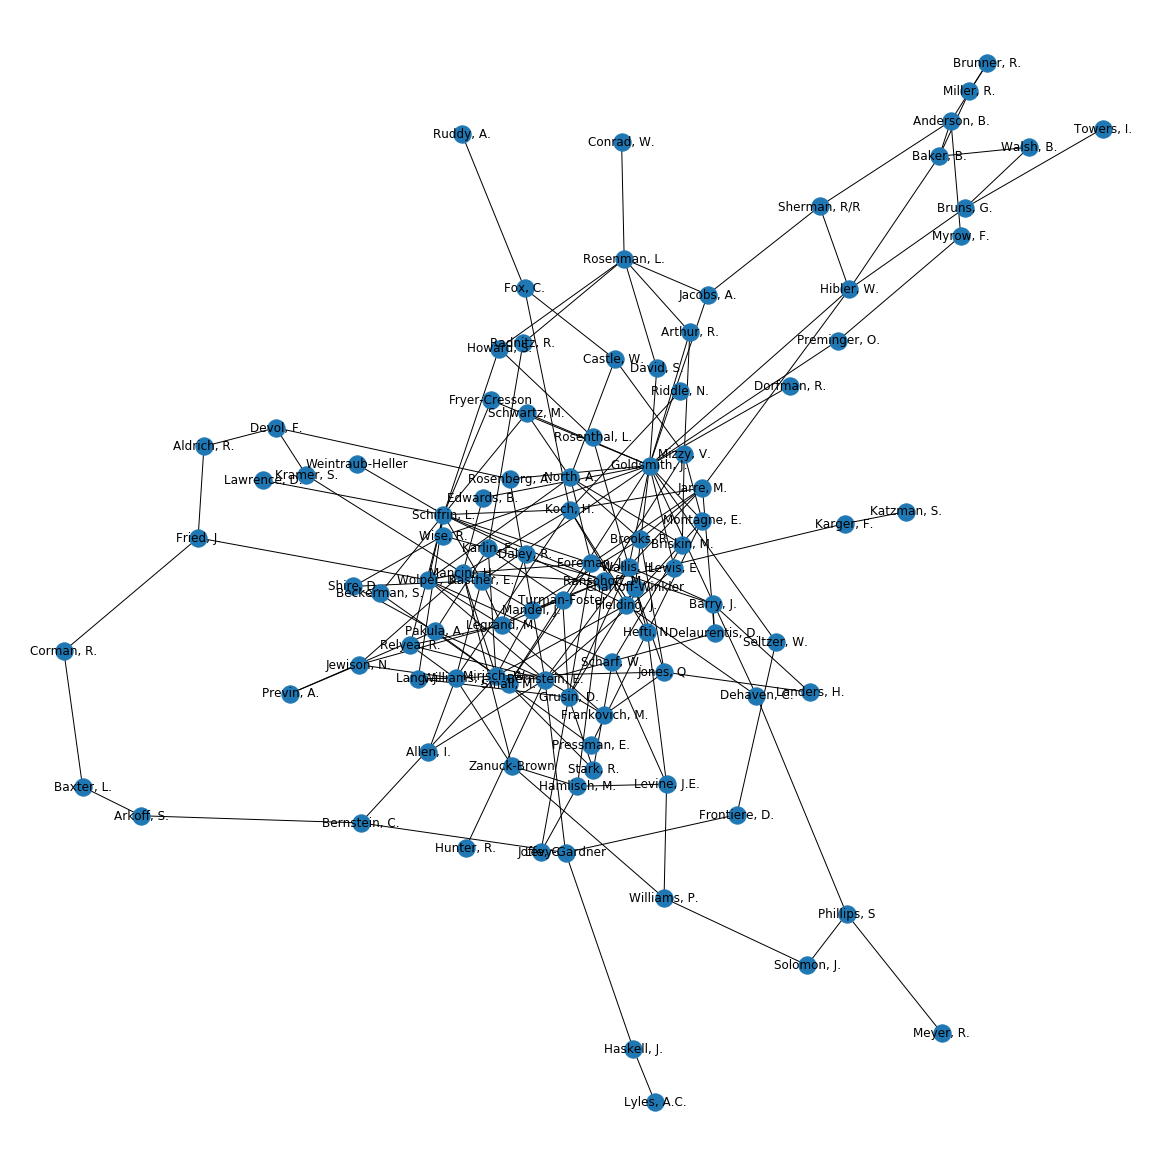

In [13]:
plt.rcParams['figure.figsize'] = [16, 16]
labels = nx.get_edge_attributes(g,'weight')
labels
nx.draw_spring(g, with_labels='true')